In [31]:
! conda install -y -c conda-forge pyldavis

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::scikit-learn==0.22.1=py36hd81dba3_0
  - defaults/linux-64::bkcharts==0.2=py36_0
  - defaults/noarch::dask==2.14.0=py_0
  - defaults/linux-64::pytorch==1.4.0=cuda101py36h02f0884_0
  - defaults/linux-64::pytest-arraydiff==0.3=py36h39e3cac_0
  - defaults/linux-64::bottleneck==1.3.2=py36heb32a55_0
  - defaults/linux-64::pywavelets==1.1.1=py36h7b6447c_0
  - defaults/noarch::pytest-astropy==0.8.0=py_0
  - defaults/linux-64::numexpr==2.7.1=py36h423224d_0
  - defaults/linux-64::h5py==2.10.0=py36h7918eee_0
  - defaults/linux-64::numpy-base==1.18.1=py36hde5b4d6_1
  - defaults/linux-64::patsy==0.5.1=py36_0
  - defaults/linux-64::scikit-image==0.16.2=py36h0573a6f_0
  - defaults/linux-64::matplotlib-base==3.1.3=py36hef1b27d_0
  - defaults/linux-64::pytables==3.6.1=py36h71ec239_0
  - defaults/linux-64::mkl_fft==1.0.15=py36ha843

In [34]:
! conda install -y scipy

Solving environment: done

## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs:
    - scipy


The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2020.6.2~ --> pkgs/main::ca-certificates-2020.6.24-0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge::certifi-2020.6.20-py36h9~ --> pkgs/main::certifi-2020.6.20-py36_0
  openssl            conda-forge::openssl-1.1.1g-h516909a_1 --> pkgs/main::openssl-1.1.1g-h7b6447c_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [102]:
import sys
import pickle
import dill
import numpy as np
import pandas as pd
import html.parser
import gensim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

from tensorflow.python.keras.preprocessing.text import Tokenizer

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
df = pd.read_csv("../data/Reviews.csv")

In [5]:
sys.path.insert(0, '..')

%load_ext autoreload
%autoreload 2

In [6]:
from utils.text_processing import apply_regexes, unescape_html, remove_html_tags, remove_line_breaks, preprocess

# Text Preprocessing

In [7]:
df['cleaned_text'] = df['Text'] + ' ' + df['Summary']
df['cleaned_text'].fillna("", inplace=True)

df['cleaned_text'] = df['cleaned_text'] \
    .apply(lambda x: unescape_html(remove_html_tags(remove_line_breaks(x), 'html.parser')))

In [8]:
df['preprocessed_text'] = df['cleaned_text'].apply(preprocess)

# Standard LDA With TFIDF 

In [8]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(df['preprocessed_text'])

In [16]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(
    n_components=10, 
    learning_method='online',
    learning_offset=10.,
    max_iter=10
)

lda_tfidf = lda.fit(tfidf)

In [17]:

pickle.dump(lda_tfidf, open('../model/lda_tfidf.pkl', 'wb'))

In [21]:
def get_topics(model, words, n=10):
    for i, topic in enumerate(model.components_):
        print(f"Topic {i}:")
        print()
        print(" ".join(
            [words[i] for i in topic.argsort()[: -n - 1: -1]]))
        print('\n')
    print()

In [25]:
get_topics(lda_tfidf, tfidf_vectorizer.get_feature_names())

Topic 0:

peanut butter cinnamon pretzel cooky pb cookie popchips oreo call


Topic 1:

pumpkin blood beer pup punch root soda nutty yuck flax


Topic 2:

raspberry trap stocking remembered watermelon stinky bonsai tree taffy intended


Topic 3:

dog cat food treat love pet chicken training puppy chew


Topic 4:

coffee cup bold pod keurig blend decaf smooth mountain brew


Topic 5:

sauce soup pasta noodle chicken tomato curry seasoning spicy dish


Topic 6:

great good tea like taste product flavor love one best


Topic 7:

cider gummy salsa cola addicting pas bear target salted finished


Topic 8:

jerky quaker jack beef sampler belly im jelly kcups link


Topic 9:

timely manner ride addict bomb goji dirt grapefruit tartar telling





# Gensim Model With n-Grams

In [77]:
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# import pyLDAvis
# import pyLDAvis.gensim

## Text Processing

In [59]:
text = df['preprocessed_text'].tolist()
text = [t.split(' ') for t in text]

In [60]:
bigram = gensim.models.Phrases(text, min_count=5, threshold=80)
trigram = gensim.models.Phrases(bigram[text], threshold=60)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [61]:
# See trigram example
print(trigram_mod[bigram_mod[text[3]]])

['looking', 'secret', 'ingredient', 'robitussin', 'believe', 'found', 'got', 'addition', 'root_beer', 'extract', 'ordered', 'good', 'made', 'cherry', 'soda', 'flavor', 'medicinal', 'cough_medicine']


In [62]:
text_trigrams = [trigram_mod[bigram_mod[review]] for review in text]

## Creating Corpus

In [63]:
# Create Dictionary
id2word = corpora.Dictionary(text_trigrams)

# Term Document Frequency
corpus = [id2word.doc2bow(review) for review in text_trigrams]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 2), (5, 1), (6, 2), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1)]]


In [66]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('appreciates', 1),
  ('better', 2),
  ('bought', 1),
  ('canned', 1),
  ('dog', 2),
  ('finicky', 1),
  ('food', 2),
  ('found', 1),
  ('good', 2),
  ('labrador', 1),
  ('like', 1),
  ('look', 1),
  ('meat', 1),
  ('processed', 1),
  ('product', 3),
  ('quality', 2),
  ('several', 1),
  ('smell', 1),
  ('stew', 1),
  ('vitality', 1)]]

## Building Topic Model

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=10, 
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [72]:
with open("../model/lda_gensim_tri_grams.model", 'wb') as f:
    dill.dump(lda_model, f)

In [75]:
with open("../model/lda_gensim_tri_grams.model", "rb") as f:
    lda_model = dill.load(f)

In [77]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.077*"good" + 0.074*"great" + 0.072*"taste" + 0.061*"love" + '
  '0.032*"really" + 0.025*"little" + 0.023*"chocolate" + 0.020*"delicious" + '
  '0.018*"well" + 0.016*"sweet"'),
 (1,
  '0.084*"price" + 0.077*"amazon" + 0.065*"find" + 0.059*"store" + '
  '0.044*"order" + 0.025*"item" + 0.024*"shipping" + 0.021*"per" + '
  '0.018*"arrived" + 0.017*"case"'),
 (2,
  '0.029*"food" + 0.024*"treat" + 0.023*"dog" + 0.018*"eat" + 0.015*"day" + '
  '0.012*"year" + 0.011*"two" + 0.011*"sauce" + 0.011*"cat" + 0.010*"since"'),
 (3,
  '0.130*"coffee" + 0.080*"cup" + 0.044*"favorite" + 0.025*"strong" + '
  '0.023*"bean" + 0.018*"blend" + 0.018*"dark" + 0.016*"breakfast" + '
  '0.013*"espresso" + 0.013*"bold"'),
 (4,
  '0.142*"tea" + 0.103*"hot" + 0.066*"drink" + 0.024*"green" + 0.020*"bitter" '
  '+ 0.019*"either" + 0.017*"honey" + 0.014*"cold" + 0.014*"morning" + '
  '0.013*"stevia"'),
 (5,
  '0.050*"like" + 0.036*"product" + 0.035*"one" + 0.034*"flavor" + '
  '0.022*"would" + 0.022*"get" + 

In [75]:
CoherenceModel(model=lda_model, texts=text_trigrams, dictionary=id2word, coherence='c_v').get_coherence()

0.44649299881745713

**TODO**: Coherence explanation

# Gensim Mallet Model With n-Grams

*TODO* Mallet explanation Using Same Corpus

In [79]:
from datetime import datetime
print(datetime.now())

2020-08-04 23:46:52.323141


## Building Topic Model

In [80]:
mallet_path = 'mallet-2.0.8/bin/mallet'

lda_mallet_model = gensim.models.wrappers.LdaMallet(
    mallet_path, 
    corpus=corpus, 
    num_topics=10, 
    id2word=id2word,
)

In [82]:
CoherenceModel(model=lda_mallet_model, texts=text_trigrams, dictionary=id2word, coherence='c_v').get_coherence()

0.4922391306034511

In [91]:
pprint(lda_mallet_model_small.show_topics(formatted=True))

[(17,
  '0.063*"water" + 0.060*"drink" + 0.032*"day" + 0.031*"bottle" + '
  '0.030*"taste" + 0.022*"work" + 0.018*"coconut" + 0.016*"juice" + '
  '0.016*"feel" + 0.015*"energy"'),
 (3,
  '0.101*"bag" + 0.081*"box" + 0.051*"pack" + 0.040*"package" + 0.030*"candy" '
  '+ 0.026*"size" + 0.021*"fresh" + 0.021*"oz" + 0.021*"packaging" + '
  '0.021*"ounce"'),
 (11,
  '0.204*"coffee" + 0.100*"cup" + 0.026*"strong" + 0.020*"blend" + 0.016*"pod" '
  '+ 0.015*"bean" + 0.015*"bitter" + 0.014*"smooth" + 0.014*"morning" + '
  '0.013*"bold"'),
 (5,
  '0.248*"good" + 0.155*"taste" + 0.087*"chocolate" + 0.029*"pretty" + '
  '0.019*"vanilla" + 0.018*"dark" + 0.014*"tasting" + 0.014*"cocoa" + '
  '0.012*"thing" + 0.011*"nice"'),
 (13,
  '0.027*"time" + 0.025*"work" + 0.017*"put" + 0.014*"container" + 0.014*"top" '
  '+ 0.011*"bit" + 0.011*"plastic" + 0.010*"make" + 0.010*"hand" + '
  '0.009*"long"'),
 (14,
  '0.101*"price" + 0.061*"amazon" + 0.056*"find" + 0.056*"store" + 0.054*"buy" '
  '+ 0.026*"buyin

# Finding Best Number of Topics

In [242]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    coherence_values = []
    
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(
            mallet_path, 
            corpus=corpus, 
            num_topics=num_topics, 
            id2word=dictionary
        )
        model_list.append(model)
        
        coherence_model = CoherenceModel(
            model=model, 
            texts=texts, 
            dictionary=dictionary, 
            coherence='c_v'
        )
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values

*TODO*: Mention need to resample due to time/computation limits

## Text Processing

In [126]:
df_small = resample(
    df, 
    replace=True,
    n_samples=100000,
    random_state=1,
    stratify=df['Score']
)

In [127]:
text_small = df_small['preprocessed_text'].tolist()
text_small = [t.split(' ') for t in text_small]

In [128]:
bigram_small = gensim.models.Phrases(text_small, min_count=5, threshold=80)
trigram_small = gensim.models.Phrases(bigram_small[text_small], threshold=60)  

bigram_small_mod = gensim.models.phrases.Phraser(bigram_small)
trigram_small_mod = gensim.models.phrases.Phraser(trigram_small)

In [129]:
text_trigrams_small = [trigram_small_mod[bigram_small_mod[review]] for review in text_small]

## Creating Corpus

In [130]:
# Create Dictionary
id2word_small = corpora.Dictionary(text_trigrams_small)

# Term Document Frequency
corpus_small = [id2word_small.doc2bow(review) for review in text_trigrams_small]

## Finding Best Coherence Model

In [131]:
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word_small, 
    corpus=corpus_small, 
    texts=text_trigrams_small, 
    start=5,
    step=5,
    limit=60
)

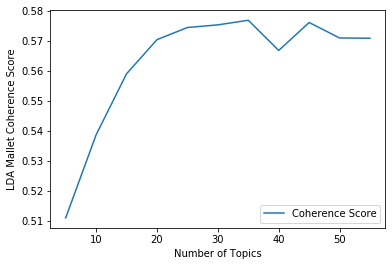

In [146]:
x = range(5, 60, 5)

plt.plot(x, coherence_values, label="Coherence Score")

plt.xlabel("Number of Topics")
plt.ylabel("LDA Mallet Coherence Score")

plt.legend(loc='best')

plt.show()

In [152]:
best_model = model_list[np.array(coherence_values).argmax()]
best_num_topics = best_model.num_topics

print(f'The best LDA model is built with {best_num_topics} topics.')

The best LDA model is built with 35 topics.


# Understanding Topics For Individual Products

*TODO*: explain for highly rated helpful reviews? 

## Adding Sentiment and Picking Product Example

In [277]:
df.loc[df['Score'] < 3, 'sentiment'] = 0
df.loc[df['Score'] >= 3, 'sentiment'] = 1

In [278]:
df[df['sentiment'] == 0].groupby('ProductId')['ProductId'].count().nlargest(5)

ProductId
B000KV61FC    167
B000KV7ZGQ    167
B0041NYV8E    146
B000X1Q1G8    141
B005K4Q1YA    141
Name: ProductId, dtype: int64

In [190]:
df.groupby('ProductId')['ProductId'].count().nlargest(5)

ProductId
B007JFMH8M    913
B0026RQTGE    632
B002QWHJOU    632
B002QWP89S    632
B002QWP8H0    632
Name: ProductId, dtype: int64

In [313]:
df_product = df[df.ProductId == 'B000KV61FC']

In [314]:
df_product.groupby('Score')['Score'].count().nlargest(5)

Score
5    197
3    101
4     91
1     89
2     78
Name: Score, dtype: int64

## Negative Reviews

In [279]:
text_product_negative = df_product[df_product['sentiment'] == 0]['preprocessed_text'].tolist()
text_product_negative = [t.split(' ') for t in text_product_negative]

In [280]:
bigram_product_negative = gensim.models.Phrases(text_product_negative, min_count=5, threshold=80)
trigram_product_negative = gensim.models.Phrases(bigram_product_negative[text_product_negative], threshold=60)  

bigram_mod_product_negative = gensim.models.phrases.Phraser(bigram_product_negative)
trigram_mod_product_negative = gensim.models.phrases.Phraser(trigram_product_negative)

In [281]:
text_trigrams_product_negative = [trigram_mod_product_negative[bigram_mod_product_negative[review]] for review in text_product_negative]

## Creating Corpus

In [282]:
# Create Dictionary
id2word_product_negative = corpora.Dictionary(text_trigrams_product_negative)

# Term Document Frequency
corpus_product_negative = [id2word_product_negative.doc2bow(review) for review in text_trigrams_product_negative]

## Building Topic Model

In [283]:
model_list_product_negative, coherence_values_product_negative = compute_coherence_values(
    dictionary=id2word_product_negative,
    corpus=corpus_product_negative, 
    texts=text_trigrams_product_negative, 
    start=2,
    step=1,
    limit=10
)

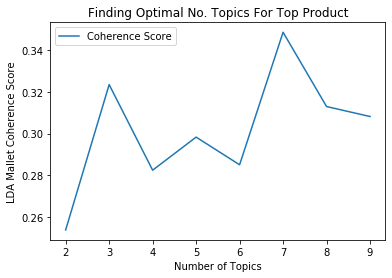

In [284]:
plt.plot(range(2, 10, 1), coherence_values_product_negative, label="Coherence Score")

plt.xlabel("Number of Topics")
plt.ylabel("LDA Mallet Coherence Score")

plt.legend(loc='best')
plt.title('Finding Optimal No. Topics For Top Product')

plt.show()

In [285]:
best_model_product_negative = model_list_product_negative[np.array(coherence_values_product_negative).argmax()]
best_num_topics_product_negative = best_model_product_negative.num_topics

print(f'The best LDA model is built with {best_num_topics_product_negative} topics.')

The best LDA model is built with 7 topics.


In [286]:
pprint(best_model_product_negative.show_topics())

[(0,
  '0.196*"rope" + 0.106*"bottle" + 0.053*"minute" + 0.049*"chewed" + '
  '0.046*"chewer" + 0.027*"chew" + 0.026*"tug" + 0.021*"figure" + 0.015*"neck" '
  '+ 0.015*"item"'),
 (1,
  '0.184*"treat" + 0.039*"play" + 0.038*"jug" + 0.027*"back" + 0.026*"end" + '
  '0.026*"thought" + 0.022*"inside" + 0.021*"long" + 0.021*"put" + '
  '0.020*"quickly"'),
 (2,
  '0.072*"plastic" + 0.037*"floor" + 0.036*"bottom" + 0.036*"lab" + '
  '0.028*"broke" + 0.028*"piece" + 0.027*"durable" + 0.023*"week" + '
  '0.023*"lasted" + 0.020*"month_old"'),
 (3,
  '0.198*"toy" + 0.061*"dog" + 0.057*"good" + 0.057*"great" + 0.032*"idea" + '
  '0.031*"hour" + 0.025*"le" + 0.017*"purchased" + 0.015*"destroyed" + '
  '0.015*"year_old"'),
 (4,
  '0.249*"dog" + 0.034*"small" + 0.030*"big" + 0.025*"lb" + 0.024*"size" + '
  '0.022*"mix" + 0.018*"smart" + 0.017*"large" + 0.015*"gave" + 0.014*"hold"'),
 (5,
  '0.089*"food" + 0.053*"kibble" + 0.051*"time" + 0.051*"hard" + '
  '0.034*"tug_jug" + 0.032*"puppy" + 0.028*"mad

## Positive Reviews

In [315]:
text_product_positive = df_product[df_product['sentiment'] == 1]['preprocessed_text'].tolist()
text_product_positive = [t.split(' ') for t in text_product_positive]

In [316]:
bigram_product_positive = gensim.models.Phrases(text_product_positive, min_count=5, threshold=80)
trigram_product_positive = gensim.models.Phrases(bigram_product_positive[text_product_positive], threshold=60)  

bigram_mod_product_positive = gensim.models.phrases.Phraser(bigram_product_positive)
trigram_mod_product_positive = gensim.models.phrases.Phraser(trigram_product_positive)

In [317]:
text_trigrams_product_positive = [trigram_mod_product_positive[bigram_mod_product_positive[review]] for review in text_product_positive]

## Creating Corpus

In [318]:
# Create Dictionary
id2word_product_positive = corpora.Dictionary(text_trigrams_product_positive)

# Term Document Frequency
corpus_product_positive = [id2word_product_positive.doc2bow(review) for review in text_trigrams_product_positive]

## Building Topic Model

In [319]:
model_list_product_positive, coherence_values_product_positive = compute_coherence_values(
    dictionary=id2word_product_positive,
    corpus=corpus_product_positive, 
    texts=text_trigrams_product_positive, 
    start=2,
    step=1,
    limit=10
)

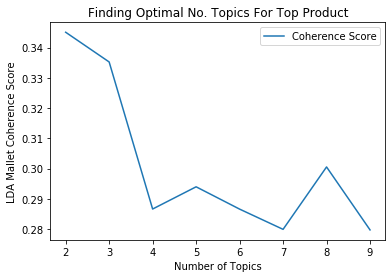

In [320]:
plt.plot(range(2, 10, 1), coherence_values_product_positive, label="Coherence Score")

plt.xlabel("Number of Topics")
plt.ylabel("LDA Mallet Coherence Score")

plt.legend(loc='best')
plt.title('Finding Optimal No. Topics For Top Product')

plt.show()

In [321]:
best_model_product_positive = model_list_product_positive[np.array(coherence_values_product_positive).argmax()]
best_num_topics_product_positive = best_model_product_positive.num_topics

print(f'The best LDA model is built with {best_num_topics_product_positive} topics.')

The best LDA model is built with 2 topics.


In [322]:
pprint(best_model_product_positive.show_topics())

[(0,
  '0.052*"dog" + 0.041*"rope" + 0.039*"food" + 0.019*"time" + 0.019*"kibble" + '
  '0.019*"bottle" + 0.011*"small" + 0.011*"rubber" + 0.010*"size" + '
  '0.010*"hard"'),
 (1,
  '0.096*"toy" + 0.048*"treat" + 0.037*"dog" + 0.031*"love" + 0.031*"jug" + '
  '0.024*"great" + 0.019*"tug" + 0.017*"good" + 0.016*"put" + 0.016*"play"')]
